In [1]:
import kete
import matplotlib.pyplot as plt
import numpy as np
import datetime
import warnings

import astropy
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord

In [2]:
# Here we compute a State of the observer, this could also be constructed
# using spice kernels using kete.spice.state
sc_pos = kete.Vector([1.6207955157194764, -2.439532618937762, -0.3757900944990942],
                    kete.Frames.Ecliptic)
sc_vel = kete.Vector([0.00810409016131854, 0.005100499696532725, -0.001331612862551293],
                    kete.Frames.Ecliptic)

# now it is correctly formatted, load it
time_jd = 2460600.500800741

# Now there is a final state of the observer
sc_state = kete.State("WISE", time_jd, sc_pos, sc_vel)


# Build the corner position of the FOV in RA/DEC, and build those into vectors
# The WCS will raise a warning because the FITs files produced by WISE use an
# old format.
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    frame_wcs = WCS(frame.header)
corners = []
dx, dy = 20, 20
for x, y in zip([0, 0, dx, dx], [0, dy, dy, 0]):
    coord = frame_wcs.pixel_to_world(x, y).icrs
    corners.append(kete.Vector.from_ra_dec(coord.ra.deg, coord.dec.deg))

# Build a generic FOV from the corners and the state of the observer
fov = kete.fov.RectangleFOV.from_corners(corners, sc_state)

NameError: name 'frame' is not defined

In [ ]:
# Load orbit data from the MPC
mpc_obs = kete.mpc.fetch_known_orbit_data()

# Convert that data to State objects.
mpc_states = kete.mpc.table_to_states(mpc_obs)

# It takes a while to propagate 1.5 million asteroids 14 years...
mpc_states = kete.propagate_n_body(mpc_states, time_jd)

In [ ]:
mpc_states

In [ ]:
visible_obj = kete.fov_state_check(mpc_states, [fov], include_asteroids=True)[0]

In [ ]:
visible_obj

## Test 2

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


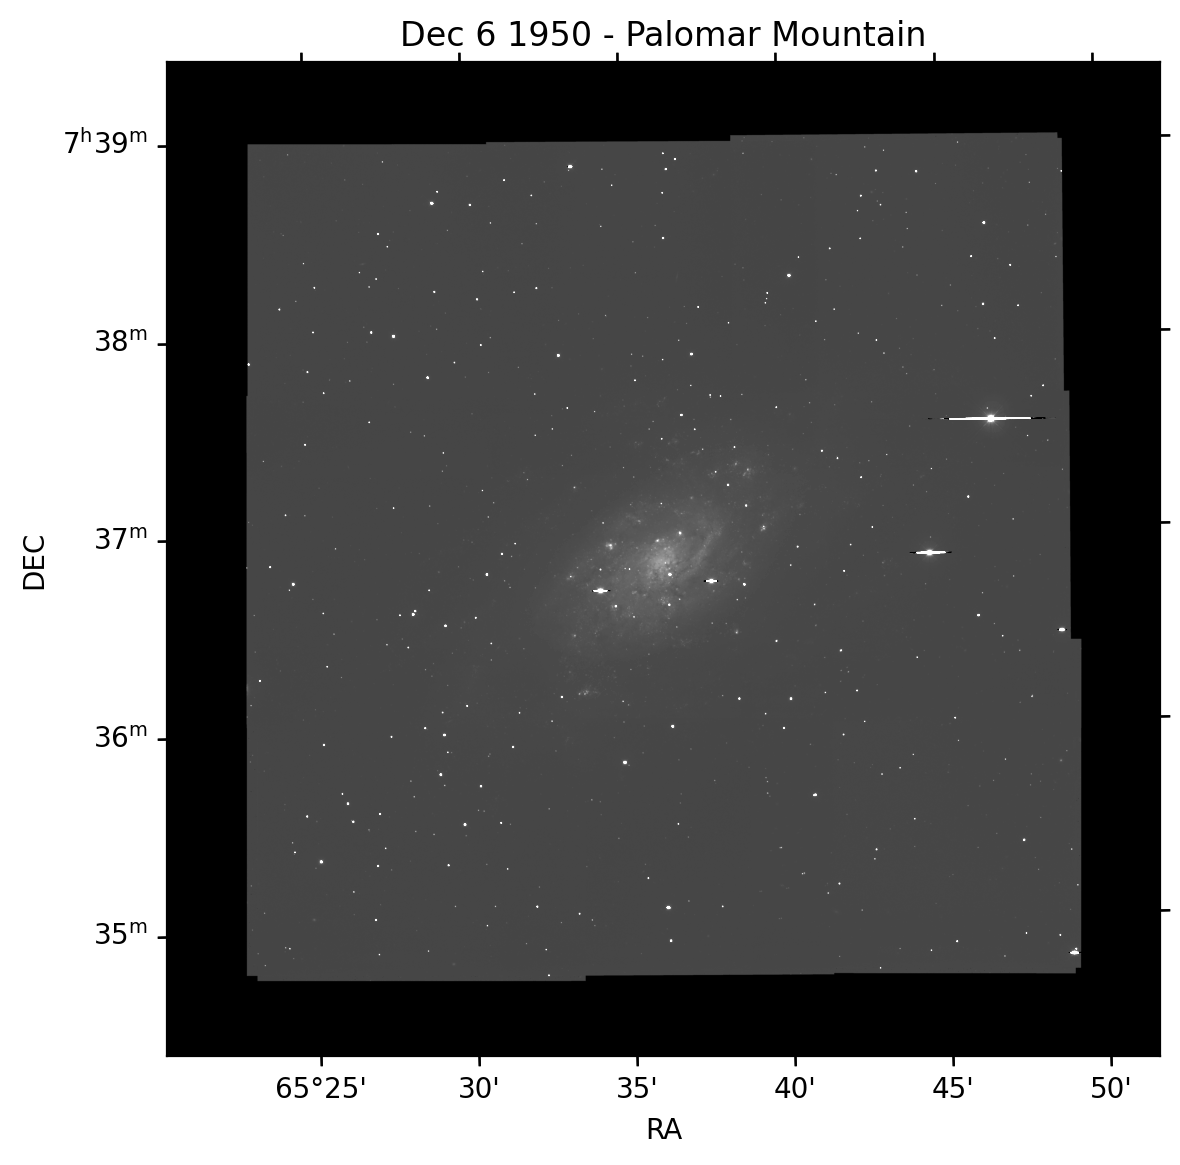

In [3]:
# load the fits file and associated WCS
frame = fits.open("ngc2403_V_dr4.fits")[0]
wcs = WCS(frame.header)

# Time of observation, approximately 3 am local time
# Taken from table A1 of the paper cited above.
jd = kete.Time(2433622.977, scaling='utc').jd

earth = kete.spice.get_state("Earth", jd)
fov = kete.fov.RectangleFOV.from_wcs(wcs, earth)

# Plot the frame
kete.irsa.plot_fits_image(frame)
plt.title("Dec 6 1950 - Palomar Mountain")
plt.tight_layout()

In [4]:
table = kete.mpc.fetch_known_orbit_data()
table = table[[str(t).isdigit() for t in table['desig']]]
table = table[table['ecc'] < 0.5]
table = table[table['peri_dist'] < 4]
states = kete.mpc.table_to_states(table)

# It takes a while to propagate 1.5 million asteroids 14 years...
states = kete.propagate_n_body(states, jd)

In [15]:
table = kete.mpc.fetch_known_orbit_data()
states = kete.mpc.table_to_states(table)
states = kete.propagate_n_body(states, 2460710.762130)

Impact detected between Name("2008 TC3") <-> earth at time 2454746.6180044445 (2008-10-07T02:48:50.400+00:00)
Impact detected between Name("2014 AA") <-> earth at time 2456659.605350349 (2014-01-02T02:30:35.086+00:00)
Impact detected between Name("2015 FF415") <-> earth at time 2458266.658127209 (2018-05-28T03:46:33.006+00:00)
Impact detected between Name("2022 EB5") <-> earth at time 2459650.3937348765 (2022-03-11T21:25:49.509+00:00)
Impact detected between Name("2022 WJ1") <-> earth at time 2459902.8576111346 (2022-11-19T08:33:48.418+00:00)
Impact detected between Name("2023 CX1") <-> earth at time 2459988.630800741 (2023-02-13T03:07:11.999+00:00)
Impact detected between Name("2024 BX1") <-> earth at time 2460330.5266094888 (2024-01-21T00:37:09.875+00:00)
Impact detected between Name("2024 RW1") <-> earth at time 2460558.1967432345 (2024-09-04T16:42:09.431+00:00)


In [5]:
vis = kete.fov_state_check(states, [fov], include_asteroids=True)[0]

Text(0.5, 1.0, 'Dec 6 1950 - Annotated')

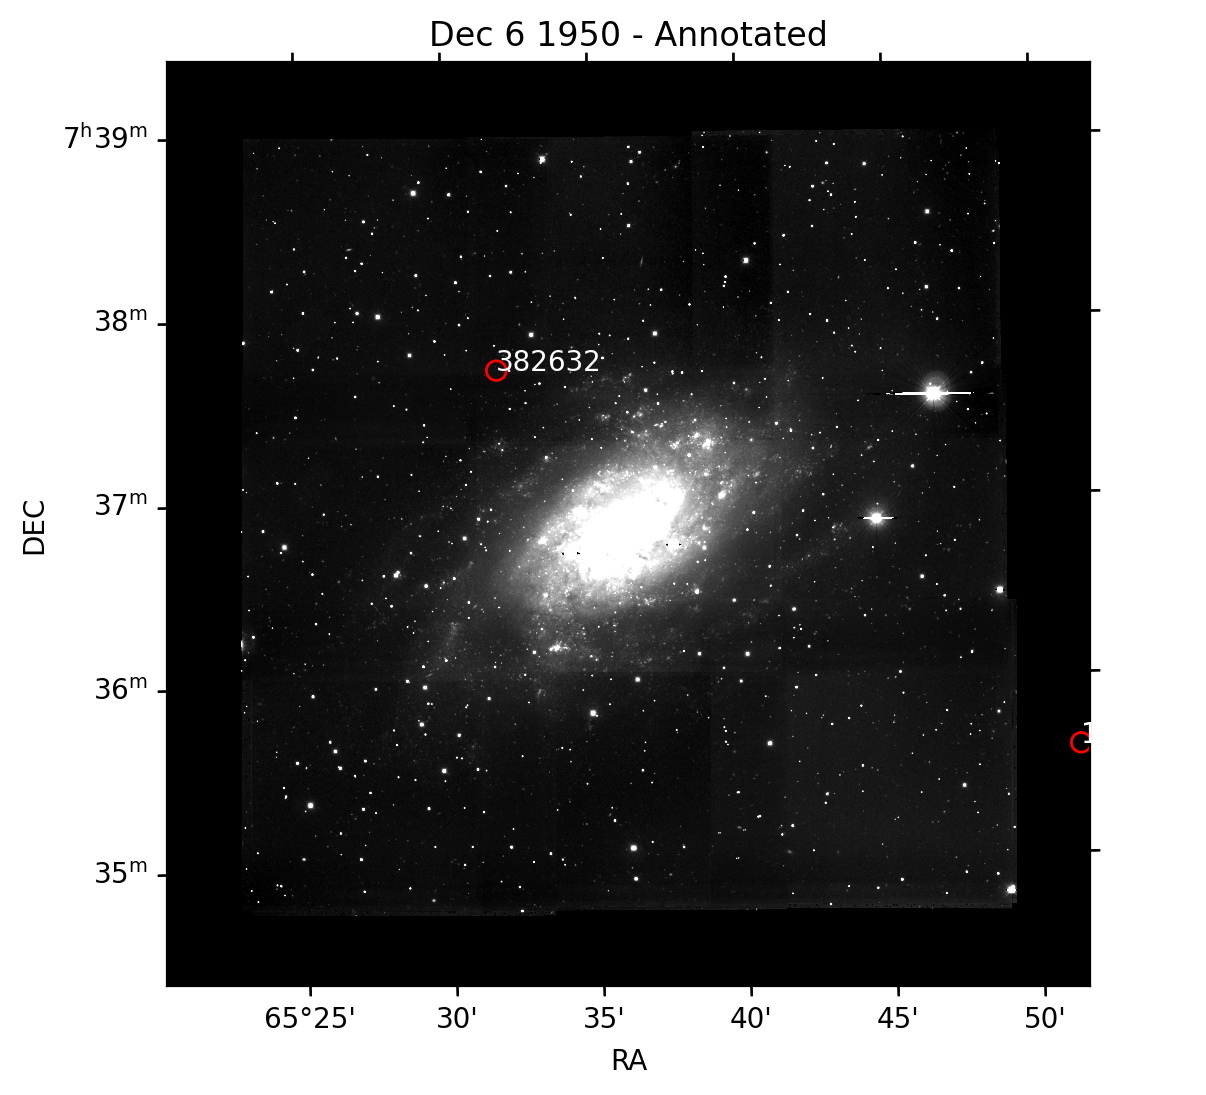

In [6]:
wcs = kete.irsa.plot_fits_image(frame, percentiles=(40, 99))
for idx in range(len(vis)):
    vec = vis.obs_vecs[idx]
    kete.irsa.annotate_plot(wcs, vec, style='o', px_gap=10, text=vis[idx].desig)

plt.title("Dec 6 1950 - Annotated")

In [8]:
type(wcs)

astropy.wcs.wcs.WCS

In [11]:
wcs

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 114.214167 65.602556 
CRPIX : 3079.37 3091.44 
CD1_1 CD1_2  : -1.6717352819144e-06 8.46239321155856e-05 
CD2_1 CD2_2  : 8.45701695067445e-05 1.67279802947724e-06 
NAXIS : 6188  6194

In [10]:
fov

GenericRectangle(pointing=Vector([-0.169411510734, 0.707873822953, 0.685721802781], Ecliptic), observer=State(desig="earth", jd=2433622.9773725, pos=[0.24694022878620886, 0.9536790865115992, 0.00011134186653233291], vel=[-0.016941305424988916, 0.004253031503126638, 7.174879508443487e-7], frame=Ecliptic, center_id=10), lon_width=0.5239263119360763, lat_width=0.5237515436477239)

In [ ]:
kete.fov_state_check(states, [fov], include_asteroids=True)

In [13]:
table

,desig,g_phase,h_mag,group_name,peri_dist,ecc,incl,lon_node,peri_arg,peri_time,epoch,arc_len,name
0,1,0.15,3.34,MBA,2.547548,0.079184,10.58790,80.25414,73.28579,2.459920e+06,2.460601e+06,81450.75,Ceres
1,2,0.15,4.11,MBA,2.131950,0.230438,34.92186,172.90614,310.89226,2.460011e+06,2.460601e+06,80355.00,Pallas
2,3,0.15,5.18,MBA,1.986328,0.256109,12.98815,169.83829,247.81975,2.460037e+06,2.460601e+06,80355.00,Juno
3,4,0.15,3.25,MBA,2.148439,0.090001,7.14398,103.70474,151.67629,2.460902e+06,2.460601e+06,74145.75,Vesta
4,5,0.15,6.99,MBA,2.093559,0.187251,5.35914,141.46063,359.23648,2.460438e+06,2.460401e+06,65379.75,Astraea
...,...,...,...,...,...,...,...,...,...,...,...,...,...
756987,756988,0.15,18.35,MBA,2.176889,0.144094,3.51977,287.03394,343.25314,2.460357e+06,2.460601e+06,4748.25,None
756991,756992,0.15,16.82,MBA,2.536741,0.183919,2.26633,128.57732,198.09499,2.460193e+06,2.460601e+06,6209.25,None
756994,756995,0.15,18.96,Amor,1.238745,0.368584,38.47990,153.80370,233.96853,2.460270e+06,2.460601e+06,4017.75,None
756995,756996,0.15,18.52,MBA,1.859323,0.201159,2.75418,144.35639,144.11575,2.459977e+06,2.460601e+06,8035.50,None


In [9]:
states

[State(desig="1", jd=2433622.9773725, pos=[1.0002263836719778, -2.735050126537326, -0.2616626034057934], vel=[0.009175031653555297, 0.00293822346779465, -0.00161437678948582], frame=Ecliptic, center_id=10),
 State(desig="2", jd=2433622.9773725, pos=[-0.15730598716182762, -2.6360713825418434, 1.834201326499283], vel=[0.008549935300088931, -0.0019057225315752967, 0.0006675983667441426], frame=Ecliptic, center_id=10),
 State(desig="3", jd=2433622.9773725, pos=[-2.530276694891586, -2.0494532346772267, 0.5565533334471322], vel=[0.0046190203569709985, -0.006712177450919507, 0.0013666689305207689], frame=Ecliptic, center_id=10),
 State(desig="4", jd=2433622.9773725, pos=[1.5733981523426261, 1.9980581395292303, -0.2528035394339122], vel=[-0.007787181693778453, 0.006710491824679844, 0.0007356015118942642], frame=Ecliptic, center_id=10),
 State(desig="5", jd=2433622.9773725, pos=[-0.8887644451166239, -2.5076068106771294, 0.2358840618537983], vel=[0.008927732927466177, -0.005198138479149225, -0.0